In [1]:
import pandas as pd

In [2]:
BATCH_SIZE = 100
HIDDEN_SIZE = 32
EMBEDDING_LEN = 300
EPOCH = 1500

In [3]:
accepted = pd.read_excel('ICLR_accepted.xlsx', index_col=[0])
rejected = pd.read_excel('ICLR_rejected.xlsx', index_col=[0])
accepted.rename({0: 'name'}, axis = 1, inplace=True)
rejected.rename({0: 'name'}, axis = 1, inplace=True)
accepted['label'] = 1
rejected['label'] = 0

df_train = pd.concat([accepted[50:], rejected[50:]]).reset_index().drop('index', axis=1)
df_test = pd.concat([accepted[:50], rejected[:50]]).reset_index().drop('index', axis=1)

print(df_train)
print(df_test)

df_train.to_csv('ICLR_train.csv', encoding='utf-8')
df_test.to_csv('ICLR_test.csv', encoding='utf-8')

                                                   name  label
0     Unsupervised Representation Learning by Predic...      1
1     Emergent Communication in a Multi-Modal, Multi...      1
2     FastGCN: Fast Learning with Graph Convolutiona...      1
3     Emergent Translation in Multi-Agent Communication      1
4     An efficient framework for learning sentence r...      1
5     NerveNet: Learning Structured Policy with Grap...      1
6     Learning Latent Representations in Neural Netw...      1
7                    Adversarial Dropout Regularization      1
8                                 Demystifying MMD GANs      1
9     Smooth Loss Functions for Deep Top-k Classific...      1
10    Deep Learning as a Mixed Convex-Combinatorial ...      1
11    Learning Approximate Inference Networks for St...      1
12    LEARNING TO SHARE: SIMULTANEOUS PARAMETER TYIN...      1
13    Model compression via distillation and quantiz...      1
14    Variational Message Passing with Structured In...

In [4]:
def split_text_only(text):
    return "".join((char if char.isalpha() else " ") for char in text).split()

In [5]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
from torchtext.data import TabularDataset

In [6]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=10)
LABEL = data.LabelField()
trn_datafields = [("id", None),
                    ("name", TEXT),
                    ("label", LABEL)]

train_data = TabularDataset(
               path="./ICLR_train.csv",
               format='csv',
               skip_header=True,
               fields=trn_datafields)

tst_datafields = [("id", None), 
                 ("name", TEXT),
                 ("label", LABEL)]

test_data = TabularDataset(path = "./ICLR_test.csv",
                    format='csv',
                    skip_header=True,
                    fields=tst_datafields)
#train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=EMBEDDING_LEN))
LABEL.build_vocab(train_data)

word_embeddings = TEXT.vocab.vectors
print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
print ("Label Length: " + str(len(LABEL.vocab)))

train_iter = data.BucketIterator(train_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
test_iter = data.BucketIterator(test_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), repeat=False, shuffle=False)

print(next(iter(train_iter)).name)
vocab_size = len(TEXT.vocab)

Length of Text Vocabulary: 2422
Vector size of Text Vocabulary:  torch.Size([2422, 300])
Label Length: 2
(tensor([[ 351, 2104,  179,   19,    1,    1,    1,    1,    1,    1],
        [  11, 1135, 1281,   10,   98, 2026,    8,  130,  185,  867],
        [1467,  688,   43,   27,    2, 1491,   39,    3,    1,    1],
        [1040,   46,    8,    5,  123,    1,    1,    1,    1,    1],
        [1471,   41,   63,    8,  290,  260,   22,   32,   75,    1],
        [  47,   35,    7,  555,   23,    5,    4,    1,    1,    1],
        [  53,  375,  620,   19,    1,    1,    1,    1,    1,    1],
        [   3,   48,   53,   28,    7,   11,    6, 1162,   64,  241],
        [2384,  873, 1419,    9,  228,   26,   10, 1908,  716,    1],
        [ 896,   34, 1136,   15,   14,    4,    2,  120,  151, 2105],
        [ 328,  131,    2,    6,  318,  181,    2,  834, 1718,    1],
        [ 747,    5,    4,    1,    1,    1,    1,    1,    1,    1],
        [  10,  614,  818,  870,    8,   29,   81, 132

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(RNN, self).__init__()
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)
        
        self.rnn = nn.RNN(embedding_length, hidden_size, num_layers=10, bidirectional=True)
        
        self.label = nn.Linear(20*hidden_size, output_size)

    def forward(self, input_sentences, batch_size=None):    
        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        h_0 = torch.zeros(20, input_sentences.size()[0], self.hidden_size).cuda()
        output, h_n = self.rnn(input, h_0)
        
        h_n = h_n.permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
        logits = self.label(h_n)
        
        return logits

net = RNN(2, HIDDEN_SIZE, vocab_size, EMBEDDING_LEN, word_embeddings)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005, betas=(0.9, 0.999))

In [9]:
def train_model(train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_data = 0
    net.cuda()
    steps = 0
    net.train()
    for idx, batch in enumerate(train_iter):
        text = batch.name[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        prediction = net(text)
        loss = criterion(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = num_corrects
        total_data += len(batch)
        
        loss.backward()
        optimizer.step()
        steps += 1
        
        total_epoch_loss += loss.item()*len(batch)
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/total_data, 100*total_epoch_acc/total_data

In [10]:
def eval_model(val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_data = 0
    net.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.name[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = net(text)
            loss = criterion(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = num_corrects
            total_data += len(batch)
            
            total_epoch_loss += loss.item()*len(batch)
            total_epoch_acc += acc.item()

    return total_epoch_loss/total_data, 100*total_epoch_acc/total_data

In [11]:
loss_value = []
train_accuracy = []
test_accuracy = []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    train_loss, train_acc = train_model(train_iter, epoch)
    _, val_acc = eval_model(train_iter)
    _, test_acc = eval_model(test_iter)
    
    loss_value.append(train_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print('Epoch', epoch, 'with loss of', train_loss, 'training acc of', train_acc, 'testing acc of', test_acc)

print('Finished Training')

Epoch 0 with loss of 0.680188023609671 training acc of 57.24696356275304 testing acc of 53.0
Epoch 1 with loss of 0.6775208137295989 training acc of 57.16599190283401 testing acc of 51.0
Epoch 2 with loss of 0.6745541119865077 training acc of 57.48987854251012 testing acc of 52.0
Epoch 3 with loss of 0.672290388389155 training acc of 58.13765182186235 testing acc of 53.0
Epoch 4 with loss of 0.6701920100069239 training acc of 59.02834008097166 testing acc of 52.0
Epoch 5 with loss of 0.6680148678269946 training acc of 58.8663967611336 testing acc of 51.0
Epoch 6 with loss of 0.6666460112038894 training acc of 58.13765182186235 testing acc of 51.0
Epoch 7 with loss of 0.6639819277925529 training acc of 59.19028340080972 testing acc of 51.0
Epoch 8 with loss of 0.661611995957641 training acc of 59.67611336032389 testing acc of 52.0
Epoch 9 with loss of 0.6598271201496665 training acc of 59.67611336032389 testing acc of 51.0
Epoch 10 with loss of 0.6568525341840891 training acc of 61.0526

Epoch 87 with loss of 0.10500785672230277 training acc of 97.4089068825911 testing acc of 50.0
Epoch 88 with loss of 0.09953794592184577 training acc of 97.4089068825911 testing acc of 51.0
Epoch 89 with loss of 0.09700511920789957 training acc of 97.48987854251013 testing acc of 52.0
Epoch 90 with loss of 0.09664650255369271 training acc of 97.97570850202429 testing acc of 50.0
Epoch 91 with loss of 0.088878869090365 training acc of 97.97570850202429 testing acc of 51.0
Epoch 92 with loss of 0.08583864307234644 training acc of 98.13765182186235 testing acc of 51.0
Epoch 93 with loss of 0.0833572111873009 training acc of 98.29959514170041 testing acc of 52.0
Epoch 94 with loss of 0.07973132502694845 training acc of 98.29959514170041 testing acc of 52.0
Epoch 95 with loss of 0.07552736125856276 training acc of 98.70445344129554 testing acc of 51.0
Epoch 96 with loss of 0.07312957357298508 training acc of 98.70445344129554 testing acc of 52.0
Epoch 97 with loss of 0.07064438517759686 tra

Epoch 172 with loss of 0.012757071774633911 training acc of 99.75708502024291 testing acc of 55.0
Epoch 173 with loss of 0.013760352030260723 training acc of 99.67611336032388 testing acc of 55.0
Epoch 174 with loss of 0.011535739507299927 training acc of 99.75708502024291 testing acc of 54.0
Epoch 175 with loss of 0.010985723553368678 training acc of 99.75708502024291 testing acc of 56.0
Epoch 176 with loss of 0.012180941927846264 training acc of 99.67611336032388 testing acc of 54.0
Epoch 177 with loss of 0.012326514628350072 training acc of 99.51417004048584 testing acc of 54.0
Epoch 178 with loss of 0.011235777814665183 training acc of 99.75708502024291 testing acc of 55.0
Epoch 179 with loss of 0.010874786088997234 training acc of 99.67611336032388 testing acc of 55.0
Epoch 180 with loss of 0.010920358921668911 training acc of 99.75708502024291 testing acc of 54.0
Epoch 181 with loss of 0.010555540530109092 training acc of 99.67611336032388 testing acc of 55.0
Epoch 182 with loss 

Epoch 256 with loss of 0.009789058711447637 training acc of 99.59514170040485 testing acc of 55.0
Epoch 257 with loss of 0.008452013279179391 training acc of 99.75708502024291 testing acc of 55.0
Epoch 258 with loss of 0.009455367598516739 training acc of 99.75708502024291 testing acc of 55.0
Epoch 259 with loss of 0.00922975393939718 training acc of 99.59514170040485 testing acc of 57.0
Epoch 260 with loss of 0.008993718871631874 training acc of 99.67611336032388 testing acc of 56.0
Epoch 261 with loss of 0.008311191042093371 training acc of 99.75708502024291 testing acc of 55.0
Epoch 262 with loss of 0.009045454870008294 training acc of 99.67611336032388 testing acc of 54.0
Epoch 263 with loss of 0.007954398434051135 training acc of 99.75708502024291 testing acc of 56.0
Epoch 264 with loss of 0.008207608872849253 training acc of 99.75708502024291 testing acc of 55.0
Epoch 265 with loss of 0.01019999522975974 training acc of 99.59514170040485 testing acc of 55.0
Epoch 266 with loss of

Epoch 340 with loss of 0.007839090107876038 training acc of 99.59514170040485 testing acc of 54.0
Epoch 341 with loss of 0.0077778412417276776 training acc of 99.75708502024291 testing acc of 54.0
Epoch 342 with loss of 0.00865690896347889 training acc of 99.67611336032388 testing acc of 55.0
Epoch 343 with loss of 0.007335222440749136 training acc of 99.75708502024291 testing acc of 54.0
Epoch 344 with loss of 0.008202563488652349 training acc of 99.75708502024291 testing acc of 55.0
Epoch 345 with loss of 0.008137430627604095 training acc of 99.67611336032388 testing acc of 54.0
Epoch 346 with loss of 0.008153559127963913 training acc of 99.75708502024291 testing acc of 55.0
Epoch 347 with loss of 0.008274089893786168 training acc of 99.59514170040485 testing acc of 55.0
Epoch 348 with loss of 0.00870364145865958 training acc of 99.75708502024291 testing acc of 55.0
Epoch 349 with loss of 0.008424570654831856 training acc of 99.67611336032388 testing acc of 55.0
Epoch 350 with loss o

Epoch 424 with loss of 0.007576077795674202 training acc of 99.67611336032388 testing acc of 55.0
Epoch 425 with loss of 0.007117045098521675 training acc of 99.75708502024291 testing acc of 54.0
Epoch 426 with loss of 0.007762543365513898 training acc of 99.75708502024291 testing acc of 54.0
Epoch 427 with loss of 0.008126236042592237 training acc of 99.59514170040485 testing acc of 54.0
Epoch 428 with loss of 0.007724377034922029 training acc of 99.75708502024291 testing acc of 54.0
Epoch 429 with loss of 0.007901795483703315 training acc of 99.67611336032388 testing acc of 54.0
Epoch 430 with loss of 0.007265220845739361 training acc of 99.59514170040485 testing acc of 55.0
Epoch 431 with loss of 0.00719732279617807 training acc of 99.75708502024291 testing acc of 55.0
Epoch 432 with loss of 0.007326447461950423 training acc of 99.75708502024291 testing acc of 54.0
Epoch 433 with loss of 0.00751457812650099 training acc of 99.75708502024291 testing acc of 54.0
Epoch 434 with loss of

Epoch 508 with loss of 0.0072484306151213256 training acc of 99.75708502024291 testing acc of 55.0
Epoch 509 with loss of 0.007192626436663271 training acc of 99.75708502024291 testing acc of 55.0
Epoch 510 with loss of 0.008169048792882426 training acc of 99.67611336032388 testing acc of 55.0
Epoch 511 with loss of 0.006785531273311539 training acc of 99.75708502024291 testing acc of 55.0
Epoch 512 with loss of 0.007410419411200329 training acc of 99.75708502024291 testing acc of 55.0
Epoch 513 with loss of 0.007214272401374784 training acc of 99.75708502024291 testing acc of 54.0
Epoch 514 with loss of 0.007951492449454398 training acc of 99.67611336032388 testing acc of 55.0
Epoch 515 with loss of 0.007431829176764927 training acc of 99.75708502024291 testing acc of 55.0
Epoch 516 with loss of 0.007211675796033777 training acc of 99.75708502024291 testing acc of 55.0
Epoch 517 with loss of 0.007107199463325926 training acc of 99.75708502024291 testing acc of 55.0
Epoch 518 with loss

Epoch 592 with loss of 0.0069553935363029055 training acc of 99.75708502024291 testing acc of 55.0
Epoch 593 with loss of 0.007103176082169585 training acc of 99.75708502024291 testing acc of 55.0
Epoch 594 with loss of 0.0074368928971998245 training acc of 99.75708502024291 testing acc of 55.0
Epoch 595 with loss of 0.00715438954448252 training acc of 99.75708502024291 testing acc of 56.0
Epoch 596 with loss of 0.00814879877749182 training acc of 99.59514170040485 testing acc of 55.0
Epoch 597 with loss of 0.007529625425922123 training acc of 99.59514170040485 testing acc of 54.0
Epoch 598 with loss of 0.007798617143774978 training acc of 99.67611336032388 testing acc of 54.0
Epoch 599 with loss of 0.007236833068606282 training acc of 99.75708502024291 testing acc of 55.0
Epoch 600 with loss of 0.007014524667117997 training acc of 99.75708502024291 testing acc of 55.0
Epoch 601 with loss of 0.0070684803917255585 training acc of 99.75708502024291 testing acc of 55.0
Epoch 602 with loss

Epoch 676 with loss of 0.0072473571466108565 training acc of 99.75708502024291 testing acc of 55.0
Epoch 677 with loss of 0.007337933697272092 training acc of 99.75708502024291 testing acc of 56.0
Epoch 678 with loss of 0.006812133548591806 training acc of 99.75708502024291 testing acc of 56.0
Epoch 679 with loss of 0.0072238579550206565 training acc of 99.75708502024291 testing acc of 56.0
Epoch 680 with loss of 0.006968626493271365 training acc of 99.75708502024291 testing acc of 55.0
Epoch 681 with loss of 0.006838239730818401 training acc of 99.75708502024291 testing acc of 55.0
Epoch 682 with loss of 0.006849432861051137 training acc of 99.75708502024291 testing acc of 55.0
Epoch 683 with loss of 0.0070968175589765405 training acc of 99.75708502024291 testing acc of 56.0
Epoch 684 with loss of 0.0067891192535642604 training acc of 99.75708502024291 testing acc of 55.0
Epoch 685 with loss of 0.007719206307007957 training acc of 99.59514170040485 testing acc of 55.0
Epoch 686 with l

Epoch 760 with loss of 0.007287717908434664 training acc of 99.67611336032388 testing acc of 54.0
Epoch 761 with loss of 0.006828551667001049 training acc of 99.75708502024291 testing acc of 55.0
Epoch 762 with loss of 0.007581429525140884 training acc of 99.75708502024291 testing acc of 55.0
Epoch 763 with loss of 0.007223288233282124 training acc of 99.75708502024291 testing acc of 56.0
Epoch 764 with loss of 0.007066153331097925 training acc of 99.75708502024291 testing acc of 54.0
Epoch 765 with loss of 0.006815804281933724 training acc of 99.75708502024291 testing acc of 54.0
Epoch 766 with loss of 0.006853557835136981 training acc of 99.75708502024291 testing acc of 55.0
Epoch 767 with loss of 0.0072271976594507755 training acc of 99.75708502024291 testing acc of 56.0
Epoch 768 with loss of 0.006869418963201736 training acc of 99.75708502024291 testing acc of 55.0
Epoch 769 with loss of 0.006766427567722144 training acc of 99.75708502024291 testing acc of 55.0
Epoch 770 with loss

Epoch 844 with loss of 0.007237581372744619 training acc of 99.75708502024291 testing acc of 55.0
Epoch 845 with loss of 0.006821530883347518 training acc of 99.67611336032388 testing acc of 54.0
Epoch 846 with loss of 0.0070647772838776796 training acc of 99.75708502024291 testing acc of 54.0
Epoch 847 with loss of 0.006790841153119634 training acc of 99.75708502024291 testing acc of 54.0
Epoch 848 with loss of 0.007060254682684958 training acc of 99.75708502024291 testing acc of 54.0
Epoch 849 with loss of 0.006722072787443365 training acc of 99.75708502024291 testing acc of 54.0
Epoch 850 with loss of 0.006869577797768856 training acc of 99.75708502024291 testing acc of 54.0
Epoch 851 with loss of 0.0067782953677525525 training acc of 99.75708502024291 testing acc of 54.0
Epoch 852 with loss of 0.0066198543881394655 training acc of 99.75708502024291 testing acc of 54.0
Epoch 853 with loss of 0.0066848983625693555 training acc of 99.75708502024291 testing acc of 54.0
Epoch 854 with l

Epoch 928 with loss of 0.006622092091612262 training acc of 99.75708502024291 testing acc of 54.0
Epoch 929 with loss of 0.0068034186869952076 training acc of 99.75708502024291 testing acc of 53.0
Epoch 930 with loss of 0.006946601808102479 training acc of 99.75708502024291 testing acc of 54.0
Epoch 931 with loss of 0.006538477873567281 training acc of 99.75708502024291 testing acc of 54.0
Epoch 932 with loss of 0.006767739602510708 training acc of 99.75708502024291 testing acc of 54.0
Epoch 933 with loss of 0.006869149546333125 training acc of 99.75708502024291 testing acc of 54.0
Epoch 934 with loss of 0.00692037485903063 training acc of 99.75708502024291 testing acc of 54.0
Epoch 935 with loss of 0.006812649774396941 training acc of 99.75708502024291 testing acc of 54.0
Epoch 936 with loss of 0.006733647667494629 training acc of 99.75708502024291 testing acc of 54.0
Epoch 937 with loss of 0.006707345980345856 training acc of 99.75708502024291 testing acc of 54.0
Epoch 938 with loss 

Epoch 1012 with loss of 0.006718076162693243 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1013 with loss of 0.007058488979950021 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1014 with loss of 0.006779025303721164 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1015 with loss of 0.0067705625782108975 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1016 with loss of 0.0069213340553275484 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1017 with loss of 0.006744275886751853 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1018 with loss of 0.006548904773042427 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1019 with loss of 0.006721550899499797 training acc of 99.75708502024291 testing acc of 55.0
Epoch 1020 with loss of 0.006889991709554327 training acc of 99.59514170040485 testing acc of 54.0
Epoch 1021 with loss of 0.006674293265731011 training acc of 99.75708502024291 testing acc of 53.0
Epoch 10

Epoch 1095 with loss of 0.006695864712706341 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1096 with loss of 0.006632884826722294 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1097 with loss of 0.006683087135124989 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1098 with loss of 0.0065579468182072245 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1099 with loss of 0.006617568799733799 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1100 with loss of 0.006575237876465328 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1101 with loss of 0.006634739301118411 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1102 with loss of 0.00667826941281393 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1103 with loss of 0.0067112415688214185 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1104 with loss of 0.007078807587972899 training acc of 99.67611336032388 testing acc of 53.0
Epoch 110

Epoch 1178 with loss of 0.006610102574944285 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1179 with loss of 0.006519850883212248 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1180 with loss of 0.0065890866470676825 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1181 with loss of 0.006685196461159781 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1182 with loss of 0.006487084148454455 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1183 with loss of 0.006589486228402512 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1184 with loss of 0.006643794210868518 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1185 with loss of 0.00676744688820256 training acc of 99.67611336032388 testing acc of 53.0
Epoch 1186 with loss of 0.0065711030899405646 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1187 with loss of 0.006730053135993238 training acc of 99.75708502024291 testing acc of 53.0
Epoch 118

Epoch 1261 with loss of 0.0065979897779485505 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1262 with loss of 0.00662478678474174 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1263 with loss of 0.006518226974751699 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1264 with loss of 0.0066358167228599075 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1265 with loss of 0.006729006056431038 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1266 with loss of 0.0067112084063763785 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1267 with loss of 0.00644840435351166 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1268 with loss of 0.006562519002105354 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1269 with loss of 0.006550790570981033 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1270 with loss of 0.006683334617072863 training acc of 99.75708502024291 testing acc of 53.0
Epoch 127

Epoch 1344 with loss of 0.00658873062085234 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1345 with loss of 0.006510958689826291 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1346 with loss of 0.006395652761300158 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1347 with loss of 0.0065738960713155655 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1348 with loss of 0.0065546819943979925 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1349 with loss of 0.006480616716378621 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1350 with loss of 0.006522827090844908 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1351 with loss of 0.006553814718926322 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1352 with loss of 0.006529820104613184 training acc of 99.75708502024291 testing acc of 54.0
Epoch 1353 with loss of 0.006610338104850385 training acc of 99.75708502024291 testing acc of 53.0
Epoch 135

Epoch 1427 with loss of 0.00653901259618225 training acc of 99.75708502024291 testing acc of 52.0
Epoch 1428 with loss of 0.006404155366717053 training acc of 99.75708502024291 testing acc of 51.0
Epoch 1429 with loss of 0.00646527842112301 training acc of 99.75708502024291 testing acc of 52.0
Epoch 1430 with loss of 0.006426353629516826 training acc of 99.75708502024291 testing acc of 52.0
Epoch 1431 with loss of 0.006724742738561147 training acc of 99.75708502024291 testing acc of 51.0
Epoch 1432 with loss of 0.006516048453800306 training acc of 99.75708502024291 testing acc of 51.0
Epoch 1433 with loss of 0.0068648467483145076 training acc of 99.75708502024291 testing acc of 53.0
Epoch 1434 with loss of 0.006493893325057113 training acc of 99.75708502024291 testing acc of 51.0
Epoch 1435 with loss of 0.0065607204208497395 training acc of 99.75708502024291 testing acc of 52.0
Epoch 1436 with loss of 0.006583924520219231 training acc of 99.75708502024291 testing acc of 52.0
Epoch 1437

In [12]:
print('Loss value: ', loss_value[-1])
print('Training accuracy: ', train_accuracy[-1])
print('Testing accuracy: ', test_accuracy[-1])

Loss value:  0.006575151305147993
Training accuracy:  99.75708502024291
Testing accuracy:  51.0


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

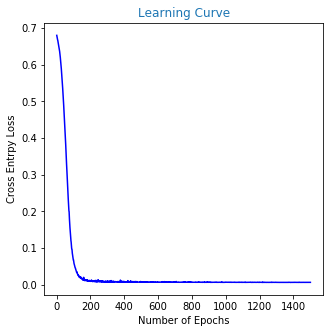

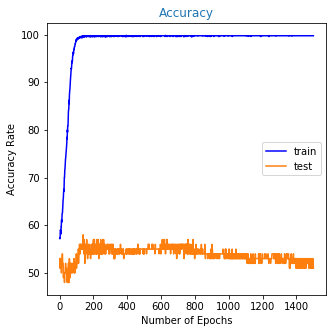

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Cross Entrpy Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(loss_value))), loss_value, 'b')

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Accuracy'.format('default'), color='C0')
ax.set_ylabel('Accuracy Rate')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(train_accuracy))), train_accuracy, 'b', label='train')
ax.plot(list(i+1 for i in range(len(test_accuracy))), test_accuracy, 'tab:orange', label='test')
ax.legend()